In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# 1. SET FOLDER NAMES
candidate_name = "vamsi krishna" # Replace with your actual name
base_path = f"ds_{candidate_name}"
csv_path = f"{base_path}/csv_files"
output_path = f"{base_path}/outputs"

# Create directories if they don't exist
os.makedirs(csv_path, exist_ok=True)
os.makedirs(output_path, exist_ok=True)

print(f"Directory {base_path} is ready.")

Directory ds_vamsi krishna is ready.


In [8]:
# 2. LOAD DATA
df_trader = pd.read_csv(f"{csv_path}/historical_data.csv")
df_sentiment = pd.read_csv(f"{csv_path}/fear_greed_index.csv")

# --- DEBUG: Print columns of df_trader to find the correct timestamp column ---
print("Columns in df_trader:", df_trader.columns)
# ------------------------------------------------------------------------------

# --- STEP 3: PRECISE DATE ALIGNMENT ---
# Converting 'Timestamp IST' to date (handling the specific format in your CSV)
df_trader['date_only'] = pd.to_datetime(df_trader['Timestamp IST'], dayfirst=True, errors='coerce').dt.date

# In your fear_greed_index.csv, the date column is 'date'
df_sentiment['date_only'] = pd.to_datetime(df_sentiment['date'], dayfirst=True, errors='coerce').dt.date

# --- STEP 4: MERGING ---
# We merge and then immediately ensure the 'Sentiment' column exists
df_merged = pd.merge(df_trader, df_sentiment, on='date_only', how='inner')

# RENAME 'classification' (from your CSV) to 'Sentiment'
if 'classification' in df_merged.columns:
    df_merged = df_merged.rename(columns={'classification': 'Sentiment'})
elif 'Classification' in df_merged.columns:
    df_merged = df_merged.rename(columns={'Classification': 'Sentiment'})

# Check if merge actually worked
if df_merged.empty:
    print("ERROR: Merge resulted in empty dataframe! Check if dates in both files overlap.")
else:
    # --- STEP 5: PREPARE DATA FOR PLOTS ---
    df_merged['is_win'] = df_merged['Closed PnL'] > 0

    analysis = df_merged.groupby('Sentiment').agg(
        Avg_PnL=('Closed PnL', 'mean'),
        Win_Rate=('is_win', 'mean'),
        Trade_Count=('Account', 'count')
    ).reset_index()

Columns in df_trader: Index(['Account', 'Coin', 'Execution Price', 'Size Tokens', 'Size USD', 'Side',
       'Timestamp IST', 'Start Position', 'Direction', 'Closed PnL',
       'Transaction Hash', 'Order ID', 'Crossed', 'Fee', 'Trade ID',
       'Timestamp'],
      dtype='object')


/tmp/ipython-input-1664263797.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Sentiment', y=col, data=analysis, palette='viridis')


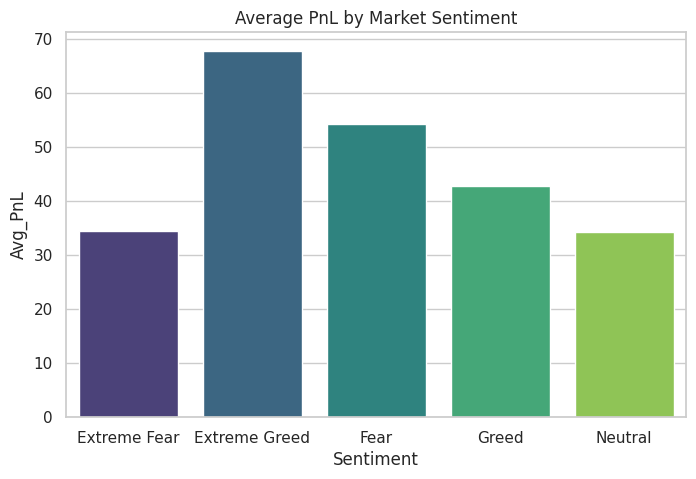

/tmp/ipython-input-1664263797.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Sentiment', y=col, data=analysis, palette='viridis')


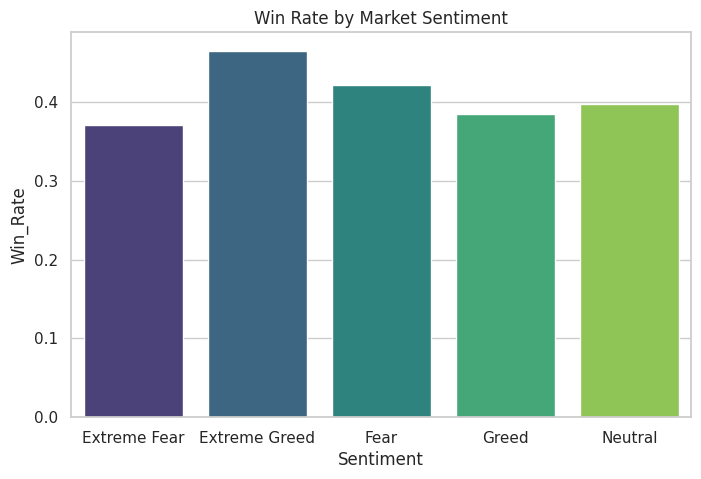

/tmp/ipython-input-1664263797.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Sentiment', y='Trade_Count', data=analysis, palette='coolwarm')


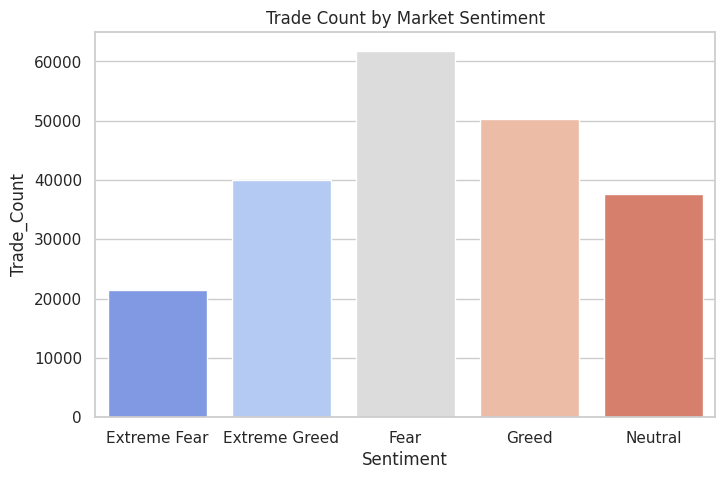

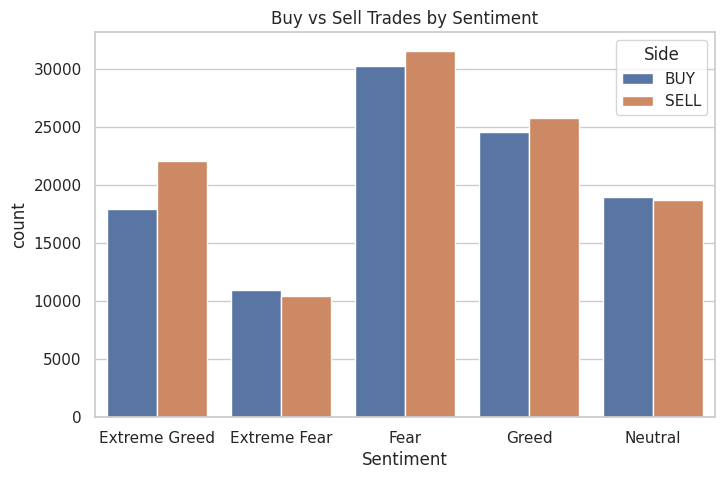


--- TOP 10 TRADERS BY PNL ---
                                       Account     Total_PnL  Win_Rate  \
27  0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23  2.143383e+06  0.337134   
0   0x083384f897ee0f19899168e3b1bec365f52a9012  1.600230e+06  0.359612   
29  0xbaaaf6571ab7d571043ff1e313a9609a10637864  9.401638e+05  0.467582   
13  0x513b8629fe877bb581bf244e326a047b249c4ff1  8.404226e+05  0.401193   
31  0xbee1707d6b44d4d52bfe19e41f8a828645437aab  8.360806e+05  0.428230   
11  0x4acb90e786d897ecffb614dc822eb231b4ffb9f4  6.777471e+05  0.486226   
15  0x72743ae2822edd658c0c50608fd7c5c501b2afbd  4.293556e+05  0.345912   
9   0x430f09841d65beb3f27765503d0f850b8bce7713  4.165419e+05  0.484236   
17  0x75f7eeb85dc639d5e99c78f95393aa9a5f1170d4  3.790954e+05  0.810876   
16  0x72c6a4624e1dffa724e6d00d64ceae698af892a0  3.605395e+05  0.303371   

    Trade_Count  
27        14733  
0          3818  
29        21192  
13        12236  
31        40184  
11         4356  
15         1590  
9         

In [12]:
# --- STEP 6: ALL VISUALIZATIONS ---
sns.set(style="whitegrid")

# 7.1 & 7.2 Average PnL and Win Rate
for col, title in [('Avg_PnL', 'Average PnL'), ('Win_Rate', 'Win Rate')]:
    plt.figure(figsize=(8, 5))
    sns.barplot(x='Sentiment', y=col, data=analysis, palette='viridis')
    plt.title(f"{title} by Market Sentiment")
    plt.savefig(f"{base_path}/outputs/{col.lower()}_by_sentiment.png")
    plt.show()

# 7.4 Trade Volume
plt.figure(figsize=(8, 5))
sns.barplot(x='Sentiment', y='Trade_Count', data=analysis, palette='coolwarm')
plt.title("Trade Count by Market Sentiment")
plt.savefig(f"{base_path}/outputs/trade_count_by_sentiment.png")
plt.show()

# 7.5 Buy vs Sell Behavior
plt.figure(figsize=(8, 5))
# Using 'Side' as found in your file
sns.countplot(x='Sentiment', hue='Side', data=df_merged)
plt.title("Buy vs Sell Trades by Sentiment")
plt.savefig(f"{base_path}/outputs/buy_sell_by_sentiment.png")
plt.show()

# --- STEP 7: TOP TRADERS ---
top_traders = df_merged.groupby('Account').agg(
    Total_PnL=('Closed PnL', 'sum'),
    Win_Rate=('is_win', 'mean'),
    Trade_Count=('Account', 'count')
).reset_index()
print("\n--- TOP 10 TRADERS BY PNL ---")
print(top_traders.sort_values(by='Total_PnL', ascending=False).head(10))

output_csv_path = f"{base_path}/outputs/merged_trader_sentiment_data.csv"
df_merged.to_csv(output_csv_path, index=False)

print(f"\n[SUCCESS] Final processed data and visualizations saved in: {base_path}/outputs/")

In [14]:
import shutil
import os

# Define your folder name
folder_to_download = 'ds_vamsi krishna'

# Create a zip file of the directory
# This will create 'ds_your_name.zip' in the current working directory
shutil.make_archive(folder_to_download, 'zip', folder_to_download)

print(f"Zip file created: {folder_to_download}.zip")

Zip file created: ds_vamsi krishna.zip
